In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../')
from src.analyze.correlations import get_corr_df

In [19]:
# change this path to the results folder
RESULT_FOLDER = '.../data/results'
RESULT_VARIANT = 'final_results'

DATASETS = ['Movielens-1m', 'Movielens-20m', 'Beauty', 'Sports',
            'BeerAdvocate', 'Diginetica', 'Zvuk', 'YooChoose']
QUANTILES = ['q09']
VALIDATION_TYPES = ['val_by_user', 'val_last_train_item', 'val_by_time']
MODELS = ['SASRec', 'GRU4Rec', 'BERT4Rec']

## Load data

In [20]:
def load_validation_test_results(validation_types, datasets, quantiles, models,
                                 results_folder, results_variant):

    test_data = defaultdict(list)
    validation_data = defaultdict(list)

    for val_type in validation_types:
        for dataset in datasets:
            for quantile in quantiles:
                for model in models:
                    directory_path = os.path.join(
                        results_folder,
                        f'global_timesplit/{val_type}/{dataset}/{quantile}/{model}/',
                        results_variant)
        
                    if not os.path.exists(directory_path):
                        continue
        
                    all_files = os.listdir(directory_path)
                    test_files = [file for file in all_files
                                  if file.startswith('test_') and file.endswith('.csv')]
                    validation_files = [file for file in all_files
                                        if file.startswith('val_') and file.endswith('.csv')]
        
                    for test_file in test_files:
                        df = pd.read_csv(os.path.join(directory_path, test_file))
                        df['dataset'] = dataset
                        df['quantile'] = quantile
                        df['model'] = model
                        split_type = f"{test_file.split('.')[0]}({val_type})"
                        test_data[split_type].append(df)
        
                    for validation_file in validation_files:
                        df = pd.read_csv(os.path.join(directory_path, validation_file))
                        df['dataset'] = dataset
                        df['quantile'] = quantile
                        df['model'] = model
                        split_type = f"{validation_file.split('.')[0]}({val_type})"
                        validation_data[split_type].append(df)

    test_data = {split_type: pd.concat(dfs, ignore_index=True)
                 for split_type, dfs in test_data.items()}
    validation_data = {split_type: pd.concat(dfs, ignore_index=True)
                       for split_type, dfs in validation_data.items()}

    # Workaround because analysis doesn't work if there are duplicated grid_points!
    if (len(models) > 1) or (len(datasets) < 1) or (len(quantiles) > 1):
        for split_type in test_data.keys():
            test_data[split_type]['grid_point'] = test_data[split_type].index
        for split_type in validation_data.keys():
            validation_data[split_type]['grid_point'] = validation_data[split_type].index

    return test_data, validation_data

In [21]:
test_data, validation_data = load_validation_test_results(
    VALIDATION_TYPES, DATASETS, QUANTILES, MODELS, RESULT_FOLDER, RESULT_VARIANT)

## Plot correlation at different K values

In [22]:
TEST_SPLIT = 'test_last'
# TEST_SPLIT = 'test_successive_userbased'
VALIDATION_SPLITS = [
    'val_last(val_by_user)',
    'val_last(val_last_train_item)',
    'val_last(val_by_time)',
]

In [23]:
validation_data_filtered = {key: value for key, value in validation_data.items()
                            if key in VALIDATION_SPLITS}

In [24]:
METRIC = 'NDCG'
CORR_TYPE = 'kendall'  # kendall, spearman, pearson

In [25]:
split_corr_dfs = {}
for split, df in validation_data_filtered.items():

    val_type = split.split('(')[1].split(')')[0]
    test_df = test_data[f'{TEST_SPLIT}({val_type})']

    corr = {}
    for dataset in DATASETS:
        test_df_dataset = test_df[test_df.dataset == dataset]
        df_dataset = df[df.dataset == dataset]
        corr[dataset] = get_corr_df(test_df_dataset, df_dataset, metrics=[METRIC]).loc[CORR_TYPE]

    split_corr_dfs[f'{TEST_SPLIT}-{split}'] = pd.DataFrame(corr)
    split_corr_dfs[f'{TEST_SPLIT}-{split}'].drop('NDCG@1', axis=0, inplace=True)

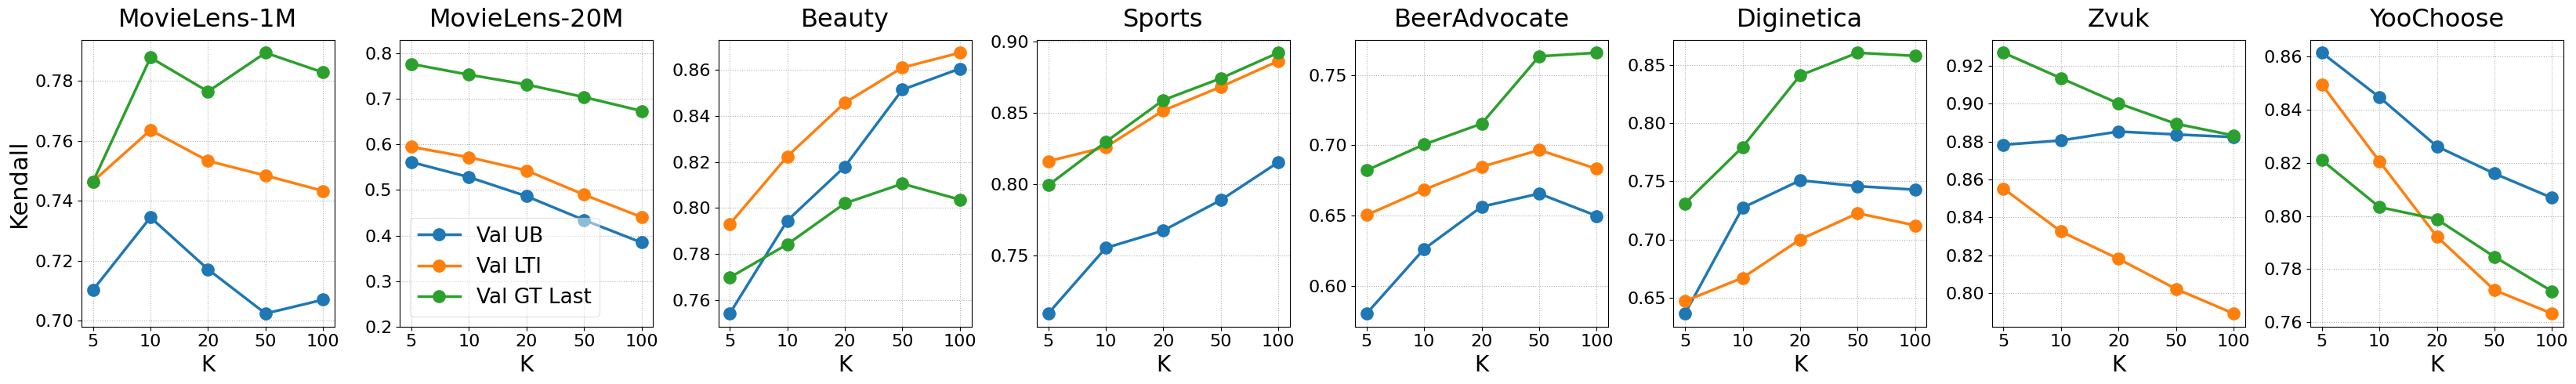

In [26]:
dataset_names = {
    'Movielens-1m': 'MovieLens-1M',
    'Movielens-20m': 'MovieLens-20M',
    # add other mappings if necessary
}


fig, axes = plt.subplots(1, len(DATASETS), figsize=(33, 5), squeeze=True)

for i, dataset in enumerate(DATASETS):
    ax = axes[i]
    display_name = dataset_names.get(dataset, dataset)
    for split_name, df in split_corr_dfs.items():
        values = df[dataset].values
        cutoffs = [x.split('@')[1] for x in df.index]
        x_positions = range(len(cutoffs))
        ax.plot(x_positions, values, marker='o', ms=11, label=split_name, linewidth=2.5)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(cutoffs)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_title(display_name, fontsize=23, pad=12)

    ax.set_xlabel("K", fontsize=20)
    if i == 0:
        ax.set_ylabel(f"{CORR_TYPE.title()}", fontsize=22)
    if i == 1:

        handles, labels = ax.get_legend_handles_labels()
        legend_labels = ['Val UB', 'Val LTI', 'Val GT Last']
        ax.legend(
            handles,
            legend_labels,
            loc='lower left',
            fontsize=19,
            framealpha=0.5
        )
        ax.set_ylim(0.2, 0.83)


    ax.grid(True, linestyle=':', alpha=1)

plt.tight_layout()
plt.show()


In [27]:
fig.savefig('test_vs_validation_corr.pdf', bbox_inches='tight', format='pdf')

## Table with average correlations

In [28]:
TEST_SPLIT = 'test_last'
# TEST_SPLIT = 'test_successive_userbased'
VALIDATION_SPLITS = [
    'val_last(val_by_user)',
    'val_last(val_last_train_item)',
    'val_last(val_by_time)',
    'val_first(val_by_time)',
    'val_random(val_by_time)',
    'val_successive_userbased(val_by_time)',
    'val_all_items_s_warm(val_by_time)'
]

In [29]:
validation_data_filtered = {key: value for key, value in validation_data.items()
                            if key in VALIDATION_SPLITS}

In [30]:
# METRICS = ['NDCG@10', 'HR@10', 'MRR@10', 'COV@10']
METRICS = ['NDCG@10', 'HR@10', 'MRR@10']
CORR_TYPES = ['kendall', 'spearman']

In [31]:
# Each model considered separately

# corr_df = []
# for split, df in validation_data_filtered.items():

#     val_type = split.split('(')[1].split(')')[0]
#     test_df = test_data[f'{TEST_SPLIT}({val_type})']
    
#     for dataset in DATASETS:
#         for model in MODELS:
#             for metric in METRICS:
#                 test_df_dataset = test_df[(test_df.dataset == dataset)
#                                           & (test_df.model == model)]
#                 df_dataset = df[(df.dataset == dataset) & (df.model == model)]
    
#                 col_name = metric
#                 df_merge = pd.merge(
#                     test_df_dataset[['grid_point', col_name]],
#                     df_dataset[['grid_point', col_name]],
#                     on='grid_point',
#                     suffixes=(f'_{TEST_SPLIT}', f'_{split}')
#                 ).dropna()
    
#                 x = df_merge[f"{col_name}_{TEST_SPLIT}"].values
#                 y = df_merge[f"{col_name}_{split}"].values
    
#                 corr = {
#                     'split': split,
#                     'model': model,
#                     'dataset': dataset,
#                     'metric': col_name,
#                     'pearson': np.corrcoef(x, y)[0, 1],
#                     'spearman': pd.Series(x).corr(pd.Series(y), method='spearman'),
#                     'kendall': pd.Series(x).corr(pd.Series(y), method='kendall'),
#                 }
    
#                 corr_df.append(corr)
       
# corr_df = pd.DataFrame(corr_df)

In [32]:
# Combine models

corr_df = []
for split, df in validation_data_filtered.items():

    val_type = split.split('(')[1].split(')')[0]
    test_df = test_data[f'{TEST_SPLIT}({val_type})']
    
    for dataset in DATASETS:
        for metric in METRICS:
            test_df_dataset = test_df[(test_df.dataset == dataset)]
            df_dataset = df[(df.dataset == dataset)]

            col_name = metric
            df_merge = pd.merge(
                test_df_dataset[['grid_point', col_name]],
                df_dataset[['grid_point', col_name]],
                on='grid_point',
                suffixes=(f'_{TEST_SPLIT}', f'_{split}')
            ).dropna()

            x = df_merge[f"{col_name}_{TEST_SPLIT}"].values
            y = df_merge[f"{col_name}_{split}"].values

            corr = {
                'split': split,
                'dataset': dataset,
                'metric': col_name,
                'pearson': np.corrcoef(x, y)[0, 1],
                'spearman': pd.Series(x).corr(pd.Series(y), method='spearman'),
                'kendall': pd.Series(x).corr(pd.Series(y), method='kendall'),
            }

            corr_df.append(corr)
       
corr_df = pd.DataFrame(corr_df)

In [33]:
mean_correlations = {}
for split in corr_df.split.unique():
    for metric in METRICS:
        condition = (corr_df.split == split) & (corr_df.metric == metric)
        mean_corr = corr_df[condition][CORR_TYPES].mean()
        mean_correlations[(split, metric)] = mean_corr

In [34]:
mean_correlations = pd.DataFrame(mean_correlations).T.unstack()
mean_correlations = mean_correlations.loc[VALIDATION_SPLITS]
mean_correlations.round(2)

kendall                spearman         \
                                        HR@10 MRR@10 NDCG@10    HR@10 MRR@10   
val_last(val_by_user)                    0.72   0.72    0.74     0.87   0.88   
val_last(val_last_train_item)            0.73   0.75    0.75     0.88   0.90   
val_last(val_by_time)                    0.78   0.79    0.79     0.93   0.93   
val_first(val_by_time)                   0.61   0.54    0.57     0.77   0.69   
val_random(val_by_time)                  0.75   0.75    0.76     0.90   0.91   
val_successive_userbased(val_by_time)    0.76   0.77    0.77     0.91   0.92   
val_all_items_s_warm(val_by_time)        0.46   0.37    0.43     0.59   0.50   

                                               
                                      NDCG@10  
val_last(val_by_user)                    0.89  
val_last(val_last_train_item)            0.90  
val_last(val_by_time)                    0.93  
val_first(val_by_time)                   0.73  
val_random(val_by_time)                  0.92  
val_successive_userbased(val_by_time)    0.92  
val_all_items_s_warm(val_by_time)        0.56

In [35]:
mean_correlations.index = [
    'UB',
    'LTI',
    'GT Last',
    'GT First',
    'GT Random',
    'GT successive',
    'GT all'
]

print(TEST_SPLIT)
mean_correlations.round(2)

test_last


kendall                spearman               
                HR@10 MRR@10 NDCG@10    HR@10 MRR@10 NDCG@10
UB               0.72   0.72    0.74     0.87   0.88    0.89
LTI              0.73   0.75    0.75     0.88   0.90    0.90
GT Last          0.78   0.79    0.79     0.93   0.93    0.93
GT First         0.61   0.54    0.57     0.77   0.69    0.73
GT Random        0.75   0.75    0.76     0.90   0.91    0.92
GT successive    0.76   0.77    0.77     0.91   0.92    0.92
GT all           0.46   0.37    0.43     0.59   0.50    0.56